In [1]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
from pulse2percept.viz import scatter_correlation
import shapes
from skimage import measure

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = shapes.load_shapes("../../data/shapes.h5", implant='ArgusII', stim_class=None)
data = data[data['electrode2'] == '']
# data = data[(data.stim_class != 'CDL0.35') & (data.stim_class != 'CDL0.75')]
data['props'] = data['image'].apply(lambda x : measure.regionprops(measure.label(x > 0.5)))
data.head()

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,implant,num_regions,orientation,pdur,stim_class,trial,x_center,y_center,img_shape,props
0,12-005,1.5,0.0,145,0.188493,20091028,0.936365,0.0,A2,,...,ArgusII,1,0.682111,0.45,SingleElectrode,9,102.857140,147.142853,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...
1,12-005,1.5,0.0,174,0.165999,20091028,0.968756,0.0,A2,,...,ArgusII,1,0.324369,0.45,SingleElectrode,17,129.333328,160.666672,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...
2,12-005,1.5,0.0,142,0.173824,20091028,0.871929,0.0,A2,,...,ArgusII,1,0.594180,0.45,SingleElectrode,30,151.000000,199.000000,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...
3,12-005,1.5,0.0,137,0.192119,20091028,0.925959,0.0,A2,,...,ArgusII,1,0.281614,0.45,SingleElectrode,38,256.000000,192.000000,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...
4,12-005,1.5,0.0,133,0.217631,20091028,0.992635,0.0,A2,,...,ArgusII,1,0.609992,0.45,SingleElectrode,51,140.000000,218.000000,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...


In [3]:
def area(row, thresh=0.5):
    return np.sum(row.image > thresh)
def eccentricity(row, thresh=0.5):
    prop = max(row.props, key = lambda x : x.area)
    return prop.eccentricity
def axis_maj(row, thresh=0.5):
    prop = max(row.props, key = lambda x : x.area)
    return prop.major_axis_length
def axis_min(row, thresh=0.5):
    prop = max(row.props, key = lambda x : x.area)
    return prop.minor_axis_length
def axis_diff(row, thresh=0.5):
    prop = max(row.props, key = lambda x : x.area)
    try:
        return prop.major_axis_length / prop.minor_axis_length
    except ZeroDivisionError:
        return np.nan
ref_fns = [area, eccentricity, axis_maj, axis_min, axis_diff]

def get_ref(df, fn):
    return df.apply(lambda x: ref[x.subject][x.electrode1][ref_fns.index(fn)], axis=1)

In [4]:
group_cols = ['subject', 'electrode1', 'electrode2']
ref = {}
bad = []
for subject in data.subject.unique():
    ref[subject] = {}
    df = data[data.subject == subject]
    for elec1 in df.electrode1.unique():
        dfe = df[df.electrode1 == elec1]
        if subject != '52-001':
            ref_amp = 1.5
        else:
            ref_amp = 1.25
        dfe = dfe[(dfe.amp1 == ref_amp) & (dfe.freq == 20)]
        if len(dfe) == 0:
            # print(f"no reference for {subject} {elec1}")
            bad.append((subject, elec1))
            ref[subject][elec1] = tuple([np.nan for fn in ref_fns])
            continue
        ref_values = [np.mean(np.array(dfe.apply(fn, axis=1))) for fn in ref_fns]
        ref[subject][elec1] = tuple(ref_values)

# Analysis w/o model

### Helper fns

In [5]:
def plot_raw(data, fn, label=None, modulate='Amp', suplabel=None, remove_nonmodulated=True):
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    for i, subject in enumerate(dat.subject.unique()):
        plt.sca(axes[i])
        plt.xlabel(modulate)
        if label is not None:
            plt.ylabel(label)
        else:
            plt.ylabel(fn.__name__)
        plt.title(subject)
        df = dat[dat.subject == subject]
        if modulate == 'Amp':
            xs = df['amp1']
        elif modulate == 'Freq':
            xs = df['freq']
        scatter_correlation(xs, df.apply(fn, axis=1), show_slope_intercept=True)
    plt.sca(axes[3])
    plt.xlabel(modulate)
    if label is not None:
        plt.ylabel(label)
    else:
        plt.ylabel(fn.__name__)
    plt.title('All Subjects')
    if modulate == 'Amp':
        xs = dat['amp1']
    elif modulate == 'Freq':
        xs = dat['freq']
    scatter_correlation(xs, dat.apply(fn, axis=1), show_slope_intercept=True)
    if suplabel is not None:
        fig.suptitle(suplabel)
    else:
        fig.suptitle(f"{modulate} vs {fn.__name__}")
    plt.show()

In [6]:
def plot_averaged(data, fn, label=None, modulate='Amp', suplabel=None, remove_nonmodulated=True):
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    
    for i, subject in enumerate(dat.subject.unique()):
        plt.sca(axes[i])   
        plt.title(subject)
        

        df = dat[dat.subject == subject]
        vals = df.apply(fn, axis=1)
        df['vals'] = vals
        avg_df = df.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean(numeric_only=False).reset_index()
        avg_vals = np.array(avg_df['vals'])
        if modulate == 'Amp':
            xs = avg_df['amp1']
        elif modulate == 'Freq':
            xs = avg_df['freq']
        scatter_correlation(xs, avg_vals, show_slope_intercept=True)
        plt.xlabel(modulate)
        if label is not None:
            plt.ylabel(label)
        else:
            plt.ylabel(fn.__name__)
        
    plt.sca(axes[3])
    plt.xlabel(modulate)
    if label is not None:
        plt.ylabel(label)
    else:
        plt.ylabel(fn.__name__)
    plt.title('All Subjects')
    
    vals = dat.apply(fn, axis=1)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    if modulate == 'Amp':
        xs = avg_df['amp1']
    elif modulate == 'Freq':
        xs = avg_df['freq']
    scatter_correlation(xs, avg_vals, show_slope_intercept=True)
    if suplabel is not None:
        fig.suptitle(suplabel)
    else:
        fig.suptitle(f"{modulate} vs averaged {fn.__name__}")
    plt.show()

In [7]:
def plot_relative_averaged(data, fn, suplabel=None, label=None, modulate='Amp', remove_nonmodulated=True, color=False, colorlabel=None):
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    
    for i, subject in enumerate(dat.subject.unique()):
        plt.sca(axes[i])
        plt.title(subject)
        df = dat[dat.subject == subject]
        vals = df.apply(fn, axis=1) / get_ref(df, fn)
        df['vals'] = vals
        avg_df = df.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
        avg_vals = avg_df['vals']
        if modulate == 'Amp':
            xs = avg_df['amp1']
        elif modulate == 'Freq':
            xs = avg_df['freq']
        if not color:
            scatter_correlation(xs, avg_vals, show_slope_intercept=True)
        else:
            isnan = np.isnan(xs) | np.isnan(avg_vals)
            xs_color = xs[~isnan]
            im = scatter_correlation(xs, avg_vals, show_slope_intercept=True, color=xs_color, marker_alpha=0.95)
        plt.xlabel(modulate)
        if label is not None:
            plt.ylabel(label)
        else:
            plt.ylabel(fn.__name__)
    
    # all subjects
    plt.sca(axes[3])
    plt.xlabel(modulate)
    if label is not None:
        plt.ylabel(label)
    else:
        plt.ylabel(fn.__name__)
    plt.title('All Subjects')
    vals = dat.apply(fn, axis=1) / get_ref(data, fn)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    if modulate == 'Amp':
        xs = avg_df['amp1']
    elif modulate == 'Freq':
        xs = avg_df['freq']
    if not color:
        scatter_correlation(xs, avg_vals, show_slope_intercept=True)
    else:
        isnan = np.isnan(xs) | np.isnan(avg_vals)
        xs_color = xs[~isnan]
        im = scatter_correlation(xs, avg_vals, show_slope_intercept=True, color=xs_color, marker_alpha=0.95)
    if suplabel is not None:
        fig.suptitle(suplabel)
    else:
        fig.suptitle(f"{modulate} vs relative {fn.__name__}")
    # if color:
    #     fig.subplots_adjust(right=0.9)
    #     cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    #     cb = fig.colorbar(im, cax=cbar_ax)
    #     cb.set_label(colorlabel)

## Amp vs Area

### Not relative

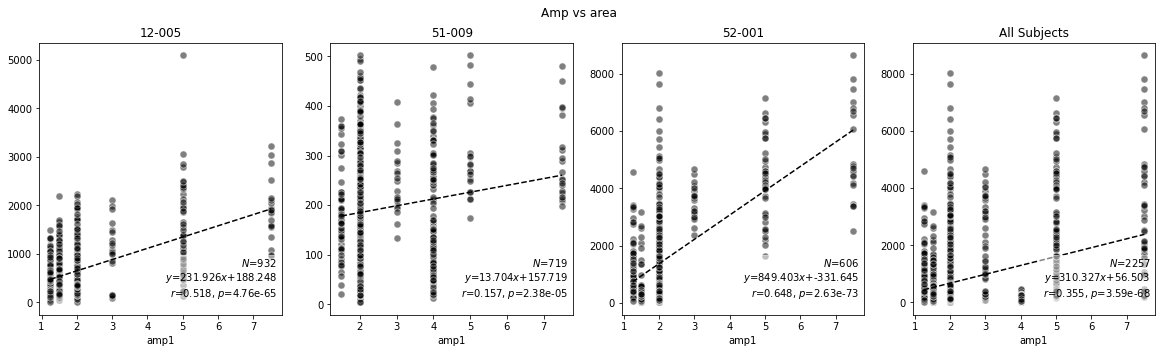

In [8]:
plot_raw(data, area)

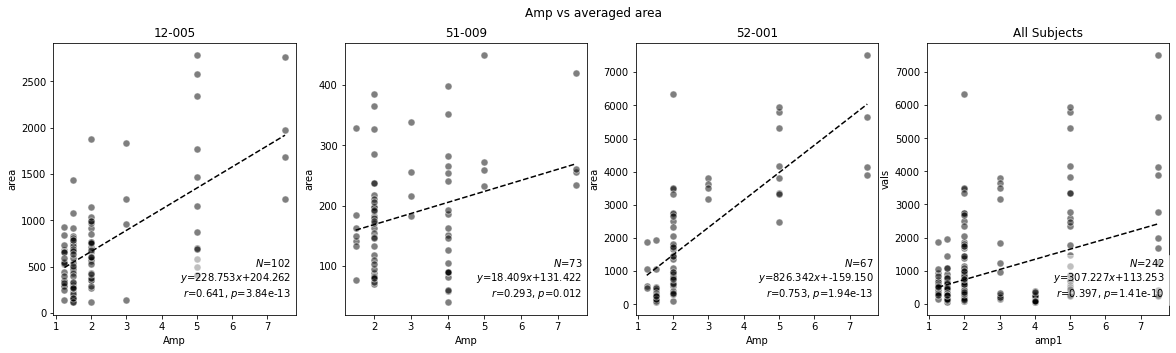

In [9]:
plot_averaged(data, area)

### Relative

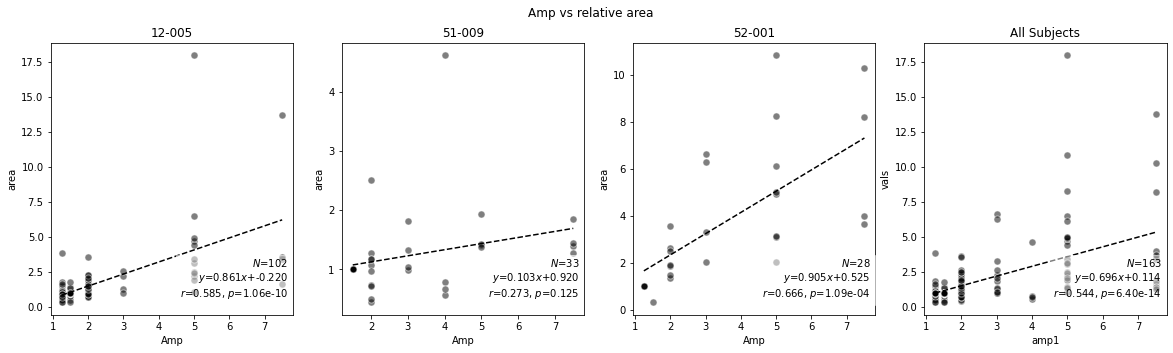

In [10]:
plot_relative_averaged(data, area)

## Freq vs area

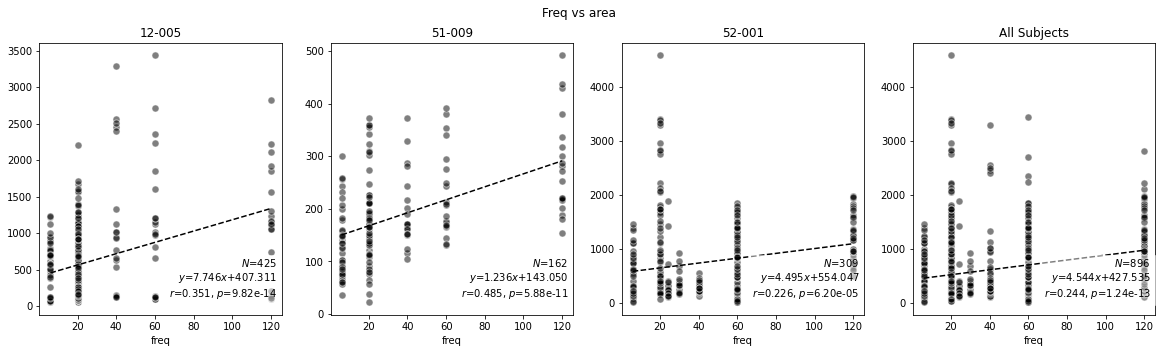

In [11]:
plot_raw(data, area, modulate='Freq')

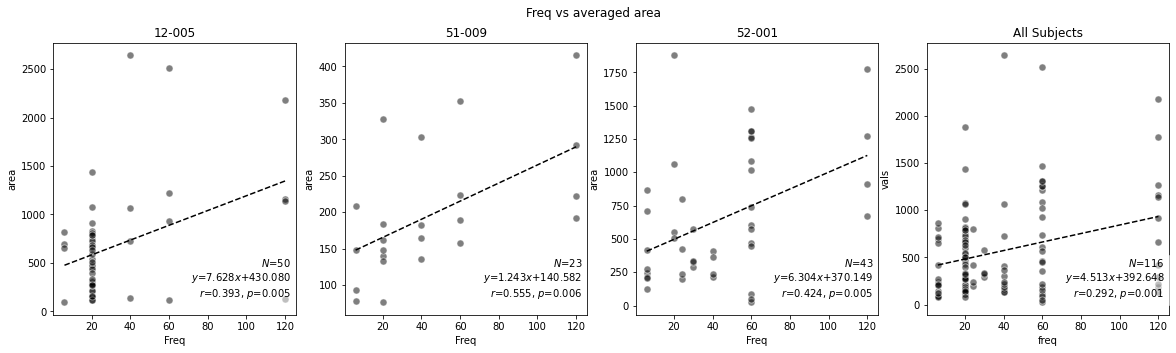

In [12]:
plot_averaged(data, area, modulate='Freq', remove_nonmodulated=True)

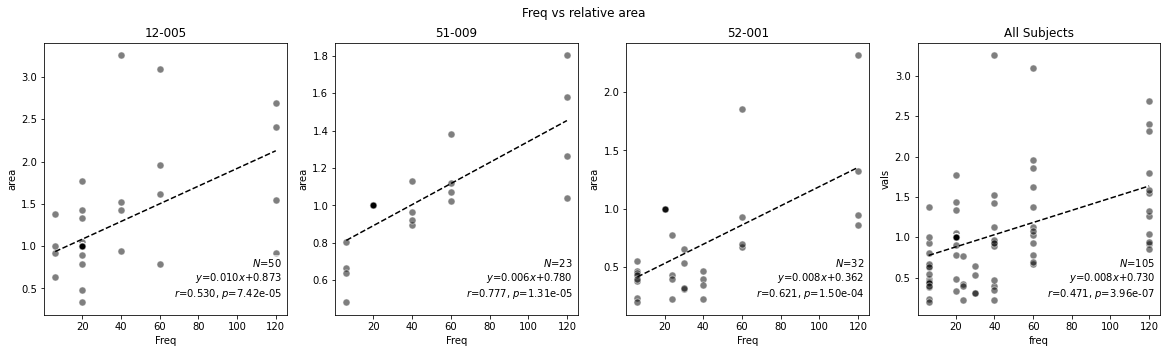

In [13]:
plot_relative_averaged(data, area, modulate='Freq', remove_nonmodulated=True)

## Streak Length

### Eccentricity 

#### Amp 

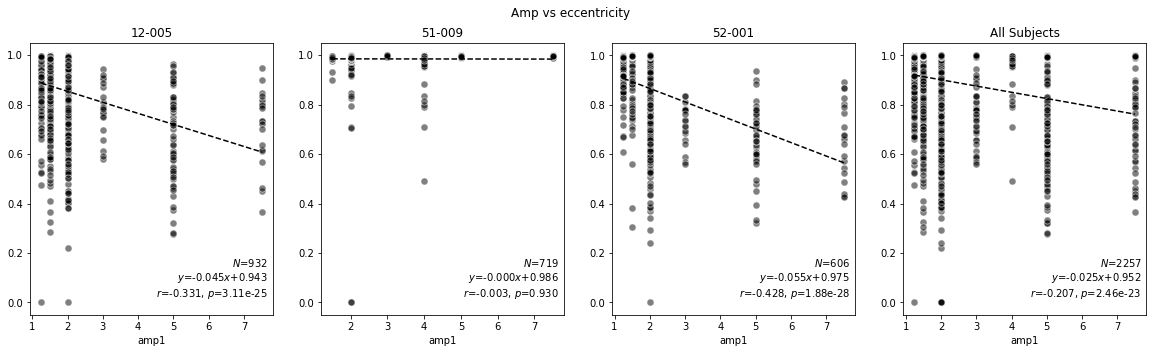

In [14]:
plot_raw(data, eccentricity)

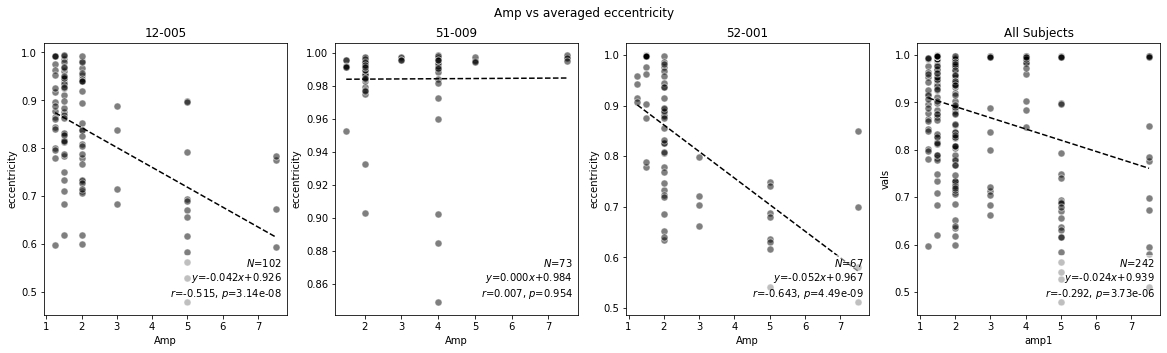

In [15]:
plot_averaged(data, eccentricity)

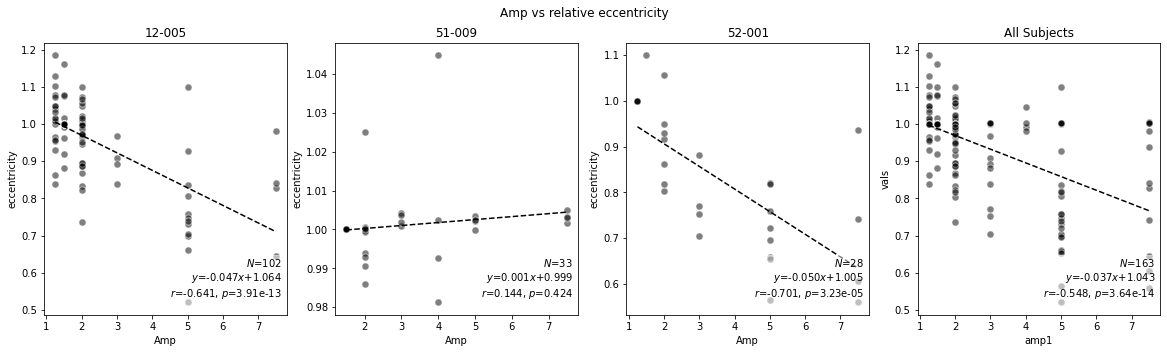

In [16]:
plot_relative_averaged(data, eccentricity)

#### Freq 

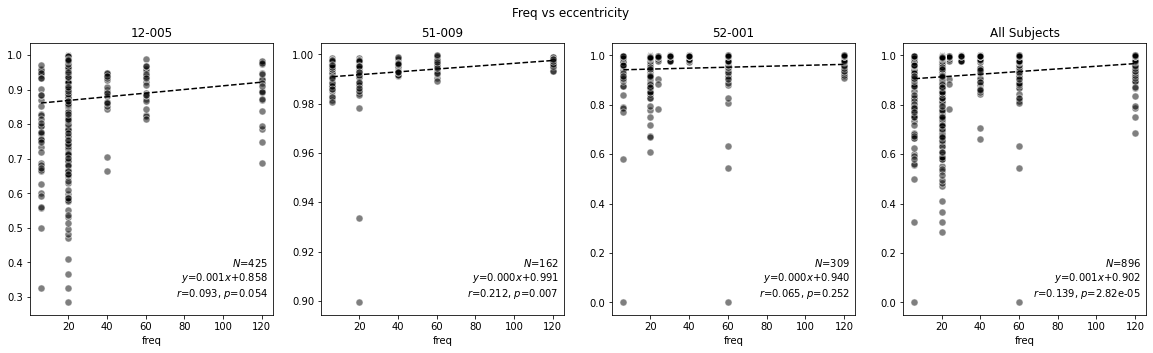

In [17]:
plot_raw(data, eccentricity, modulate='Freq')

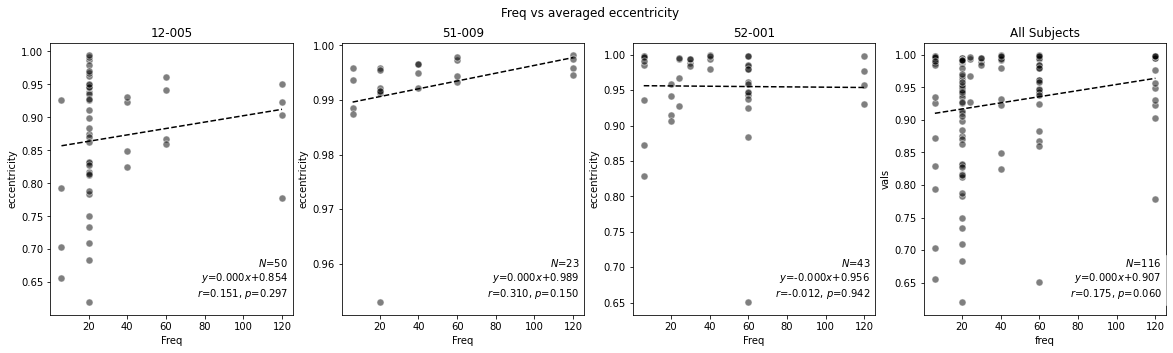

In [18]:
plot_averaged(data, eccentricity, modulate='Freq')

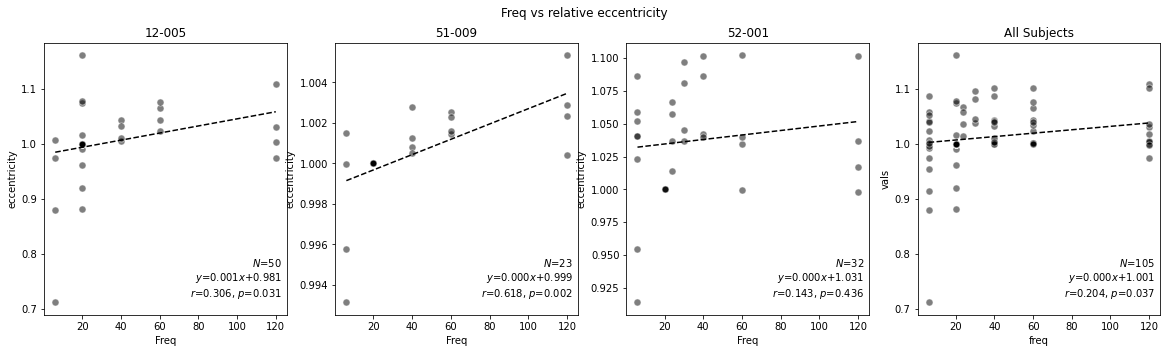

In [19]:
plot_relative_averaged(data, eccentricity, modulate='Freq')

### Major Axis Length

#### Amp 

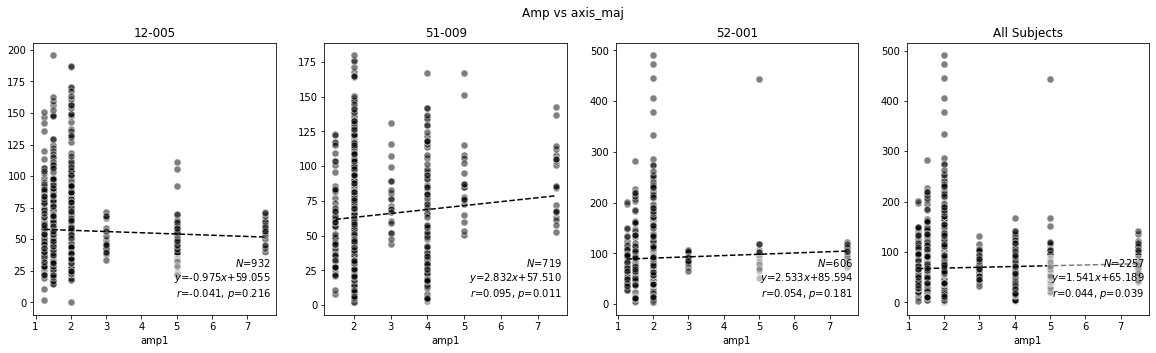

In [20]:
plot_raw(data, axis_maj)

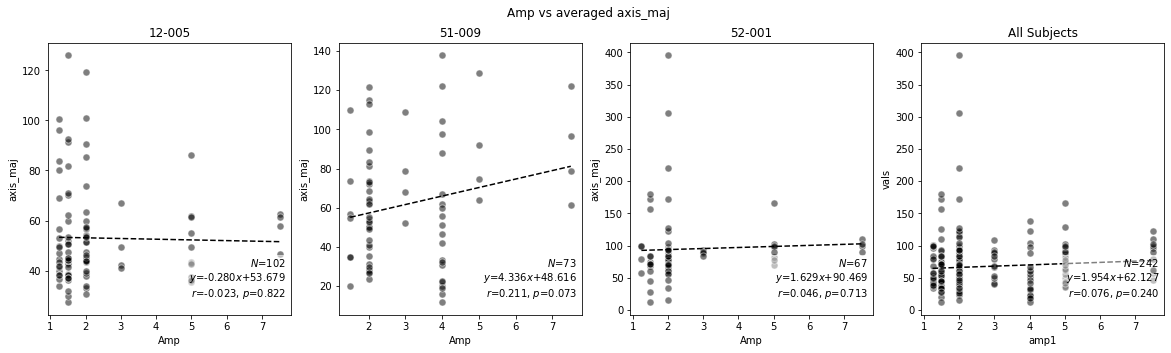

In [21]:
plot_averaged(data, axis_maj)

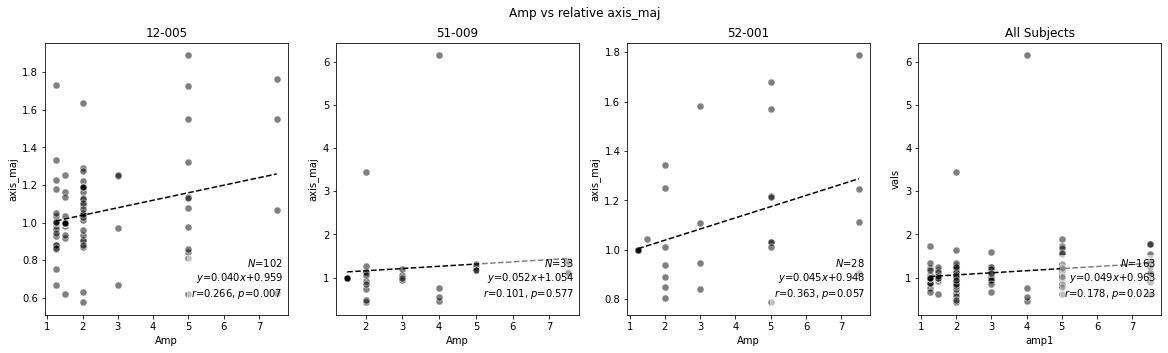

In [22]:
plot_relative_averaged(data, axis_maj)

#### Freq 

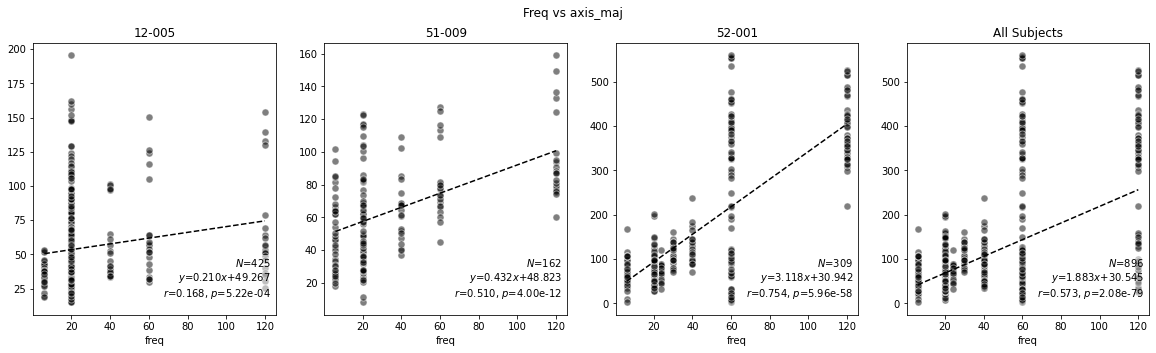

In [23]:
plot_raw(data, axis_maj, modulate='Freq')

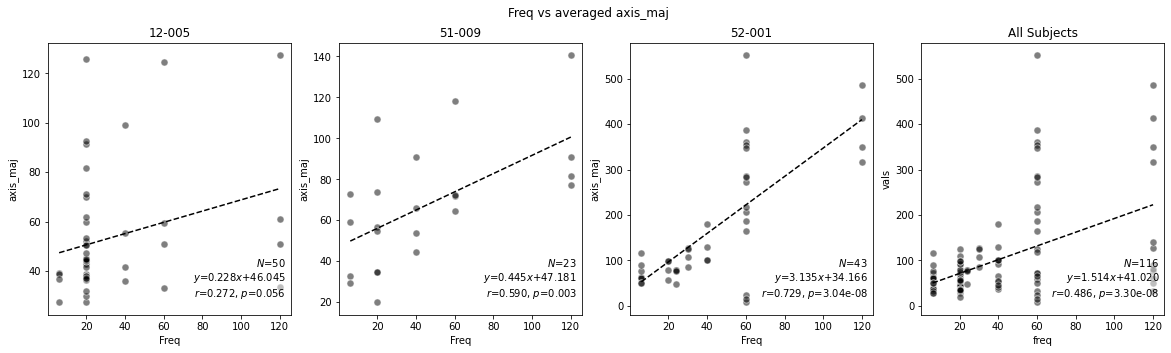

In [24]:
plot_averaged(data, axis_maj, modulate='Freq')

### Axis diff 

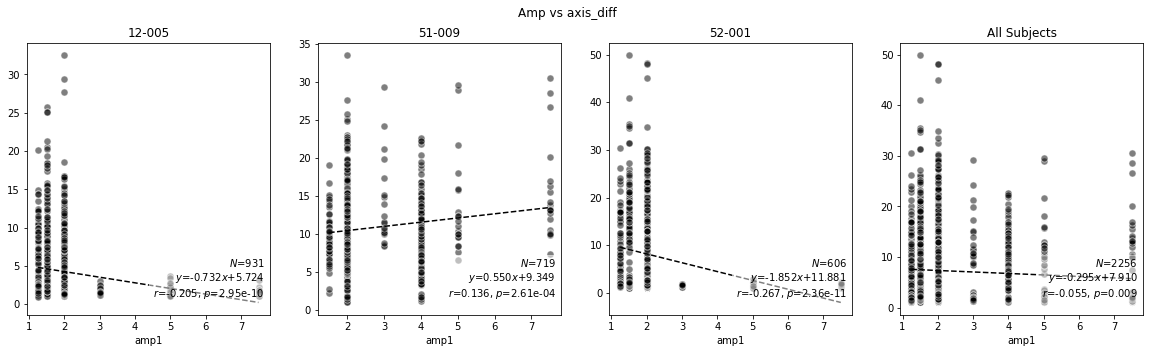

In [25]:
plot_raw(data, axis_diff)

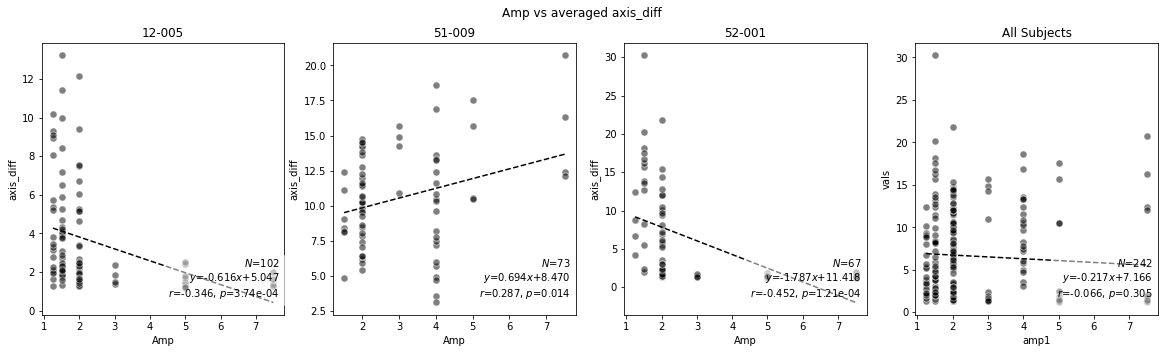

In [26]:
plot_averaged(data, axis_diff)

In [27]:
df = data[data.subject == '12-005']

In [28]:
df = df[df.freq == 20]

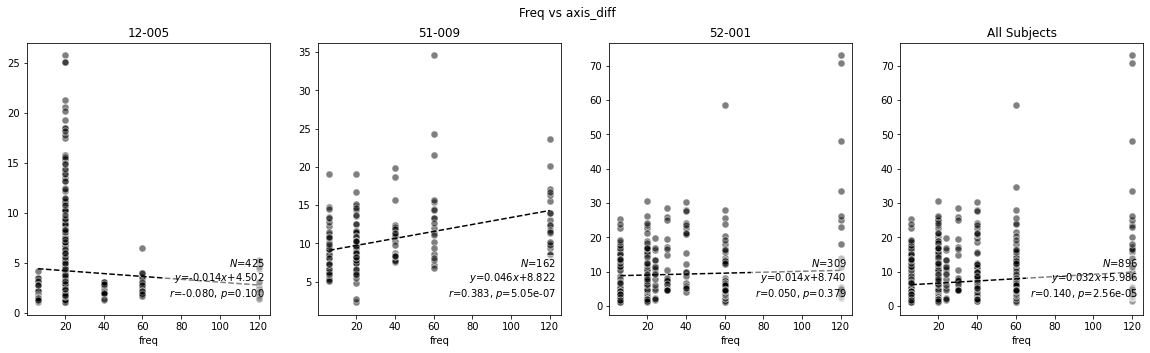

In [29]:
plot_raw(data, axis_diff, modulate='Freq')

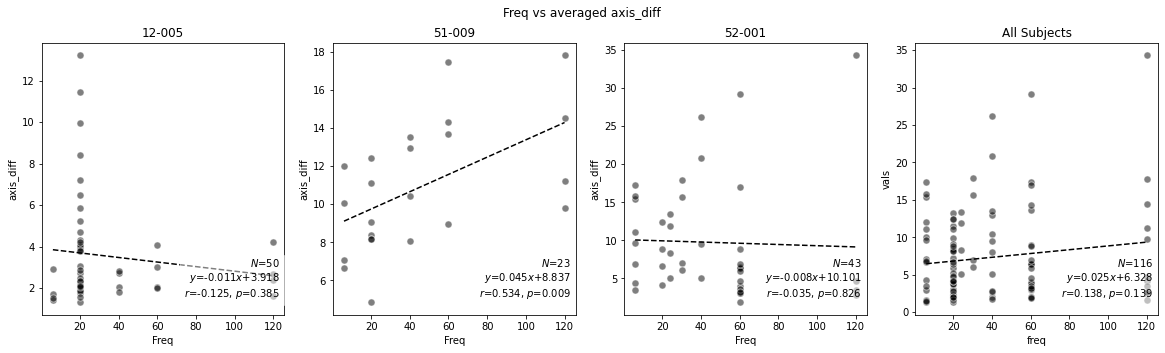

In [30]:
plot_averaged(data, axis_diff, modulate='Freq')

# Model

### Helper Functions

In [31]:
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain
from pulse2percept.implants import ArgusII, DiskElectrode, ProsthesisSystem

from sklearn.linear_model import LinearRegression
import scipy.stats as spst
from sklearn.metrics import r2_score

In [32]:
def get_percept(row, model, implant):
    implant.stim = {row.electrode1 : BiphasicPulseTrain(row.freq, row.amp1, row.pdur)}
    return model.predict_percept(implant)

def phosphene_size(percept, ref_bright=None):
    if ref_bright is None:
        ref_bright = (percept.max(axis='frames').max() - percept.max(axis='frames').min()) * 0.1 + percept.max(axis='frames').min()
    return (percept.max(axis='frames') > ref_bright).sum()

def phosphene_eccentricity(percept, ref_bright=None):
    if ref_bright is None:
        ref_bright = (percept.max(axis='frames').max() - percept.max(axis='frames').min()) * 0.1 + percept.max(axis='frames').min()
    prop = max(measure.regionprops(measure.label(percept.max(axis='frames') > ref_bright)), key = lambda x : x.area)
    return prop.eccentricity

def phosphene_bright(percept):
    return percept.data.max()
    
model_ref_fns = [phosphene_size, phosphene_bright]
def get_model_ref(df, fn):
    return df.apply(lambda x: model_ref[x.subject][x.electrode1][model_ref_fns.index(fn)], axis=1)

In [33]:
def get_relative_averaged(data, fn, remove_nonmodulated=True, modulate='Amp'):
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    vals = dat.apply(fn, axis=1) / get_ref(data, fn)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    return avg_df, avg_vals

In [34]:
def get_averaged(data, fn, remove_nonmodulated=True, modulate='Amp'):
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data

    vals = dat.apply(fn, axis=1)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    return avg_df, avg_vals

In [35]:
model_ref = {}
rholambdas = {  '12-005' : (410, 1190, 0.8606007300451295, -0.22009792182424115),
                '51-009' : (144, 1414, 0.10317693634692716, 0.9195175629336384),
                '52-001' : (437, 1420, 0.9053663293316979, 0.5252074767108121)}
for subject in data.subject.unique():
    model_ref[subject] = {}
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    model.a5 = rholambdas[subject][2]
    model.a6 = rholambdas[subject][3]
    model.build()
    df = data[data.subject == subject]
    for elec1 in df.electrode1.unique():
        dfe = df[df.electrode1 == elec1]
        if subject != '52-001':
            ref_amp = 1.5
        else:
            ref_amp = 1.25
        
        implant.stim = {elec1 : BiphasicPulseTrain(20, ref_amp, 0.45)}
        ref_percept = model.predict_percept(implant)
        ref_bright = ref_percept.data.max()
        ref_size = phosphene_size(ref_percept)
        
        model_ref[subject][elec1] = (ref_size, ref_bright)

## Amp vs Size

0.48775341219808677 0.3652757327676177
0.09937137479135681 0.7819604161871723
0.8820330689034128 0.5532605853043782


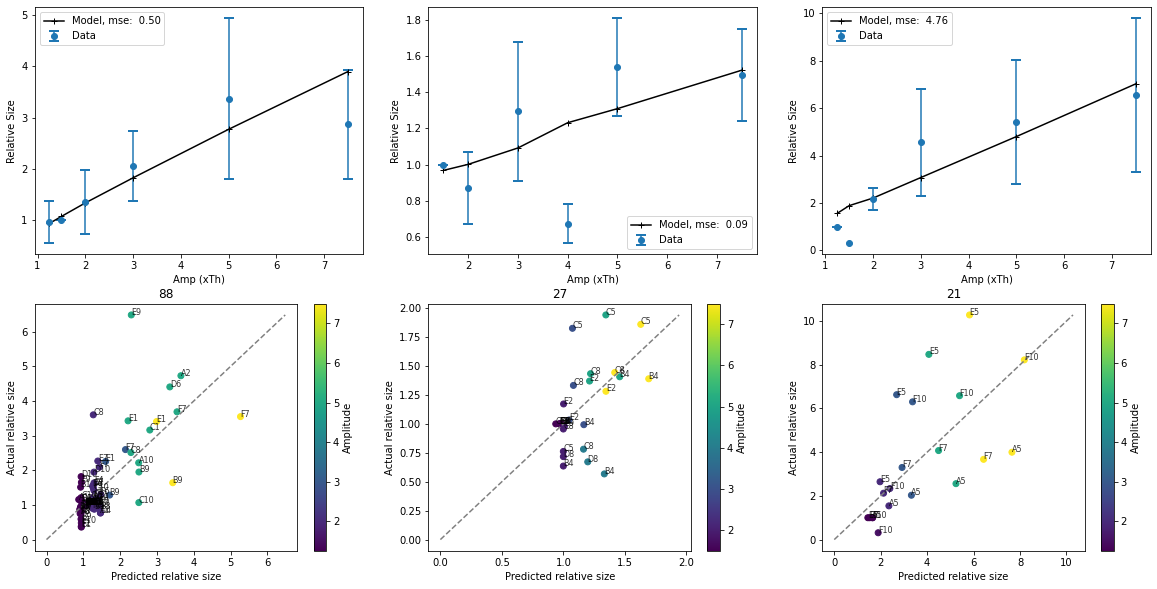

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))


bad_elecs = {'12-005' : ['D7'], '51-009' : ['F4'], '52-001':[]}

for i, subject in enumerate(data.subject.unique()):
    # get points
    df = data[data.subject == subject]
    df = df[df.freq == 20]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_areas = get_relative_averaged(df, area, modulate='Amp')
    avg_df = avg_df.dropna()
    avg_areas = avg_areas.dropna()
    avg_df['areas'] = avg_areas
    amps = avg_df.amp1
    
    
    # fit the model
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    lr = LinearRegression()
    lr.fit(np.array(amps).reshape(-1, 1), np.array(avg_areas))
    model.a5 = lr.coef_[0]
    model.a6 = lr.intercept_
    print(model.a5, model.a6)
    if subject == '52-001':
        model.a5 = 1.708
        model.a6 = 0.648
    elif subject == '12-005':
        model.a5 =  0.802
        model.a6 =  -0.031
    elif subject == '51-009':
        model.a5 = 0.152
        model.a6 = 0.78
    model.build()
    
    # simulate percepts
    avg_df['percept'] = avg_df.apply(get_percept, args=(model, implant), axis=1)
    
    avg_df['sizes'] = avg_df.percept.apply(phosphene_size) / get_model_ref(avg_df, phosphene_size)
    mse = np.mean((avg_df.sizes - avg_areas)**2)
    
    plt.sca(axes[0, i])
    # plt.scatter(amps, avg_areas, alpha=0.6)
    
    avg_drawing_sizes = avg_df.groupby(['amp1'])['areas'].mean()
    std_drawing_sizes = avg_df.groupby(['amp1'])['areas'].std()
    avg_drawing_amps = avg_df.groupby(['amp1'])['areas'].mean().reset_index()['amp1']
    # plt.scatter(avg_drawing_amps, avg_drawing_sizes, alpha=0.8)
    plt.errorbar(avg_drawing_amps, avg_drawing_sizes, yerr=std_drawing_sizes, linestyle='', marker='o', capsize=5, capthick=2, label='Data')
    
    means = avg_df.groupby(['amp1'])['sizes'].mean()
    stds = avg_df.groupby(['amp1'])['sizes'].std()
    amps = avg_df.groupby(['amp1'])['sizes'].mean().reset_index()['amp1'].unique()
    # plt.errorbar(amps, means, yerr=stds, marker='+', color='black', ecolor='red', capsize=5, capthick=2, label=f"Model, mse: {mse : .2f}")
    plt.plot(amps, means, c='black', marker='+', label=f"Model, mse: {mse : .2f}")
    
    plt.ylabel('Relative Size')
    plt.xlabel('Amp (xTh)')
    plt.legend()
    
    
    plt.sca(axes[1, i])
    plt.scatter(avg_df['sizes'], avg_areas, c=avg_df['amp1'])
    plt.colorbar(label='Amplitude')
    for x, y, elec in zip(avg_df['sizes'], avg_areas, avg_df.electrode1):
        plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
    maxval = max(avg_df['sizes'].max(), avg_areas.max())
    plt.plot( [0,maxval],[0,maxval] , linestyle='--', color='gray')
    plt.xlabel('Predicted relative size')
    plt.ylabel('Actual relative size')
    plt.title(len(avg_df))
    
    

In [37]:
def model_mse(a5a6, model, implant, data):
    a5 = a5a6[0]
    a6 = a5a6[1]
    model.a5 = a5
    model.a6 = a6
    data['percepts'] = data.apply(get_percept, args=(model, implant), axis=1)
    data['sizes'] = data.percepts.apply(phosphene_size) / get_model_ref(data, phosphene_size)
    
    return np.mean((data.sizes - data.areas)**2)
        

In [38]:
# from scipy.optimize import minimize, differential_evolution
# sols = []
# for subject in data.subject.unique():
    
#     implant, model = shapes.model_from_params(shapes.subject_params[subject])
#     model.rho = rholambdas[subject][0]
#     model.axlambda = rholambdas[subject][1]
#     model.build()


#     df = data[data.subject == subject]
#     df = df[df.freq == 20]
#     df = df[~df.electrode1.isin(bad_elecs[subject])]
#     avg_df, avg_areas = get_relative_averaged(df, area, modulate='Amp')
#     avg_df = avg_df.dropna()
#     avg_areas = avg_areas.dropna()
#     avg_df['areas'] = avg_areas
    
#     sol = differential_evolution(model_mse, ((0, 5), (-5, 5), (10, 500)), args=(model, implant, avg_df), maxiter=100, popsize=10)
#     print(sol)
#     sols.append(sol)

# model_mse([1.717, -0.71], model, implant, avg_df)

## Freq vs Size

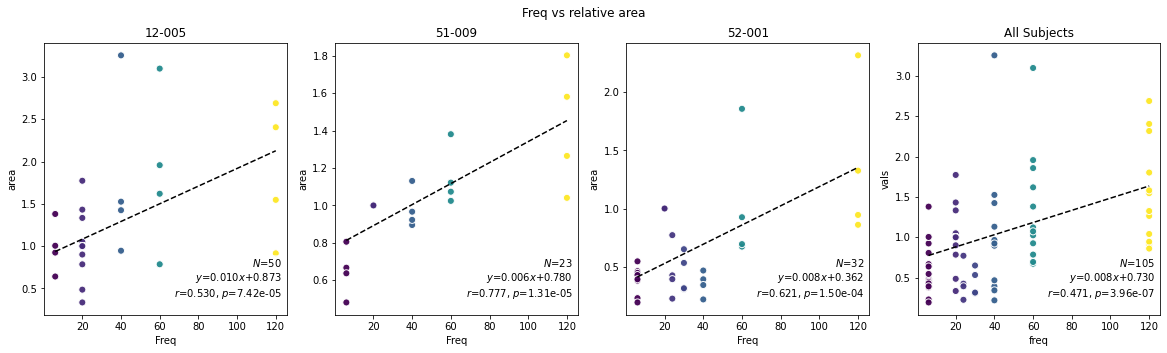

<Figure size 432x288 with 0 Axes>

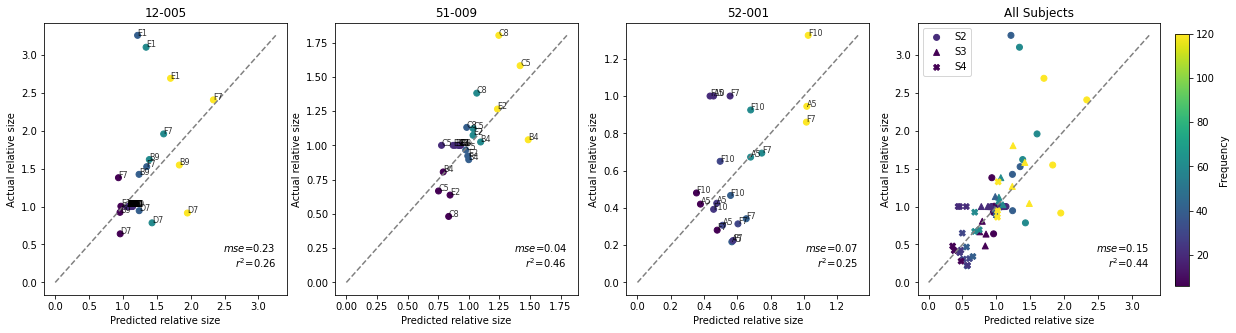

In [39]:
plot_relative_averaged(data, area, modulate='Freq', color=True, colorlabel='Frequency')
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

rholambdas = {  '12-005' : (410, 1190, 0.802, -0.031),
                '51-009' : (144, 1414, 0.152, 0.78),
                '52-001' : (437, 1420, 1.708, 0.648)}
bad_elecs = {'12-005' : [], '51-009' : [], '52-001':['E5']}
subj_data = []
for i, subject in enumerate(data.subject.unique()):
    # get points
    df = data[data.subject == subject]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_areas = get_relative_averaged(df, area, modulate='Freq')
    avg_df = avg_df.dropna()
    avg_areas = avg_areas.dropna()
    avg_df['areas'] = avg_areas
    freqs = avg_df.freq
    
    
    # fit the model
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    model.a5 = rholambdas[subject][2]
    model.a6 = rholambdas[subject][3]
    # lr = LinearRegression()
    # lr.fit(np.array(freqs).reshape(-1, 1), np.array(avg_areas))
    # model.a10 = lr.coef_[0]
    # model.a6 = lr.intercept_

    
    if subject == '12-005':
        model.a6, model.a10 = -0.2829508668414943, 0.01386980325453202
    elif subject == '51-009':
        model.a6, model.a10 = 0.5385426635343504, 0.006992905321139498
    elif subject == '52-001':
        model.a6, model.a10 = -1.6310288461517213, 0.00992617959193387
        #0.017678352500785532, 0#-0.04803093261331881
    # print(model.a10)
    model.build()
    
    # simulate percepts
    avg_df['percept'] = avg_df.apply(get_percept, args=(model, implant), axis=1)
    
    avg_df['sizes'] = avg_df.percept.apply(phosphene_size) / get_model_ref(avg_df, phosphene_size)
    mse = np.mean((avg_df.sizes - avg_areas)**2)
    
    # plt.sca(axes[0, i])
    
    # scatterplot with areas, model line plot
#     plt.scatter(freqs, avg_areas, alpha=0.6)
    
#     avg_drawing_sizes = avg_df.groupby(['freq'])['areas'].mean()
#     std_drawing_sizes = avg_df.groupby(['freq'])['areas'].std()
#     avg_drawing_amps = avg_df.groupby(['freq'])['areas'].mean().reset_index()['freq']
    # plt.scatter(avg_drawing_amps, avg_drawing_sizes, alpha=0.8)
    # plt.errorbar(avg_drawing_amps, avg_drawing_sizes, yerr=std_drawing_sizes, linestyle='', marker='o', capsize=5, capthick=2, label='Data')
    
    # means = avg_df.groupby(['freq'])['sizes'].mean()
    # stds = avg_df.groupby(['freq'])['sizes'].std()
    # freqs = avg_df.groupby(['freq'])['sizes'].mean().reset_index()['freq'].unique()
    # plt.errorbar(freqs, means, yerr=stds, marker='+', color='black', ecolor='red', capsize=5, capthick=2, label=f"Model, mse: {mse : .2f}")
    # plt.plot(freqs, means, c='black', marker='+', label=f"Model, mse: {mse : .2f}")
    
    # plt.ylabel('Relative Size')
    # plt.xlabel('Freq (Hz)')
    # plt.legend()
    
    
    plt.sca(axes[i])
    plt.scatter(avg_df['sizes'], avg_areas, c=avg_df['freq'])
    
    
    for x, y, elec in zip(avg_df['sizes'], avg_areas, avg_df.electrode1):
        plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
    maxval = max(avg_df['sizes'].max(), avg_areas.max())
    plt.plot( [0,maxval],[0,maxval] , linestyle='--', color='gray')
    
    # get r2 for model
    r = r2_score(avg_areas, avg_df.sizes)
    a = plt.gca().axis()
    t = plt.text(maxval, maxval*0.05, f"$mse$={mse:.2f}\n $r^2$={r:.2f}", va='bottom', ha='right')
    t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))
    
    plt.xlabel('Predicted relative size')
    plt.ylabel('Actual relative size')
    plt.title(subject)
    
    subj_data.append([avg_areas, avg_df.sizes, avg_df.freq])

plt.sca(axes[3])
maxval = max([max(np.max(row[0]), np.max(row[1])) for row in subj_data])
all_areas = []
all_model_areas = []
for (areas, model_areas, freqs), marker, subject in zip(subj_data, ['o', '^', 'X'], ['S2', 'S3', 'S4']):
    im = plt.scatter(model_areas, areas, c=freqs, marker=marker, label=subject)
    all_areas += list(areas)
    all_model_areas += list(model_areas)
plt.plot( [0,maxval],[0,maxval] , linestyle='--', color='gray')
plt.xlabel('Predicted relative size')
plt.ylabel('Actual relative size')
plt.title("All Subjects")
plt.legend()


all_areas = np.array(all_areas)
all_model_areas = np.array(all_model_areas)
mse = np.mean((all_areas - all_model_areas)**2)
r = r2_score(all_areas, all_model_areas)

a = plt.gca().axis()
t = plt.text(maxval, maxval*0.05, f"$mse$={mse:.2f}\n$r^2$={r:.2f}", va='bottom', ha='right')
t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("Frequency")#, rotation=0, y=-0.04, labelpad=-30)


In [56]:
def model_mse(a6a10, model, implant, data):
    a6 = a6a10[0]
    a10 = a6a10[1]
    model.a6 = a6
    model.a10 = a10
    data['percepts'] = data.apply(get_percept, args=(model, implant), axis=1)
    data['sizes'] = data.percepts.apply(phosphene_size) / get_model_ref(data, phosphene_size)
    
    return np.mean((data.sizes - data.areas)**2)
        

In [67]:
from scipy.optimize import minimize, differential_evolution
sols = {}
for subject in data.subject.unique():
    print(subject)
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    model.a5 = rholambdas[subject][2]
    model.build()


    df = data[data.subject == subject]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_areas = get_relative_averaged(df, area, modulate='Freq')
    avg_df = avg_df.dropna()
    avg_areas = avg_areas.dropna()
    avg_df['areas'] = avg_areas
    
    sol = differential_evolution(model_mse, ((-5, 5), (0, 2)), args=(model, implant, avg_df), maxiter=100, popsize=10)
    print(sol)
    print()
    sols[subject] = sol

# model_mse([1.717, -0.71], model, implant, avg_df)

12-005
     fun: 0.23179963802836193
 message: 'Optimization terminated successfully.'
    nfev: 303
     nit: 14
 success: True
       x: array([-0.28,  0.01])

51-009
     fun: 0.04189343405399286
 message: 'Optimization terminated successfully.'
    nfev: 503
     nit: 24
 success: True
       x: array([0.54, 0.01])

52-001
     fun: 0.07402844924178269
 message: 'Optimization terminated successfully.'
    nfev: 403
     nit: 19
 success: True
       x: array([-1.63,  0.01])



In [68]:
[list(s.x) for s in sols]

[[-0.2829508668414943, 0.01386980325453202],
 [0.5385426635343504, 0.006992905321139498],
 [-1.6310288461517213, 0.00992617959193387]]

## Eccentricity

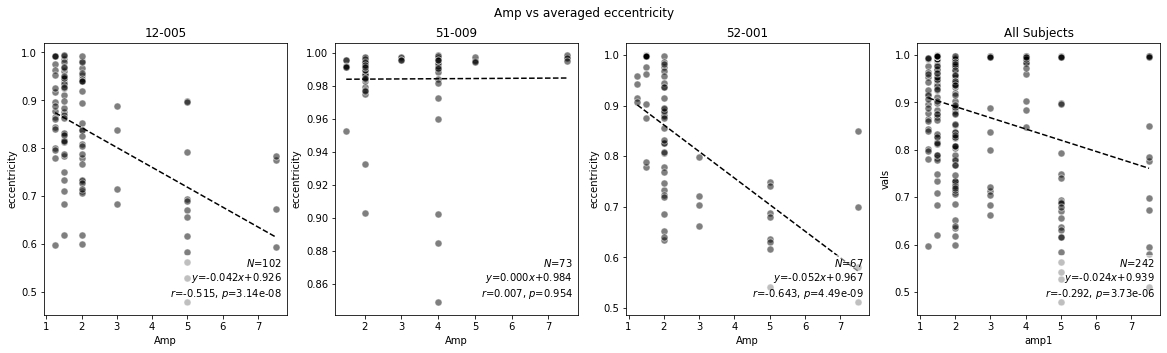

In [40]:
plot_averaged(data, eccentricity)

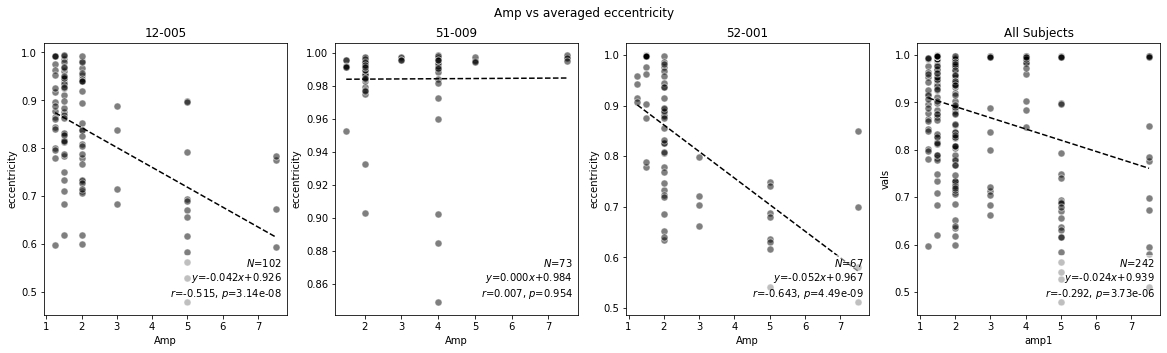

<Figure size 432x288 with 0 Axes>

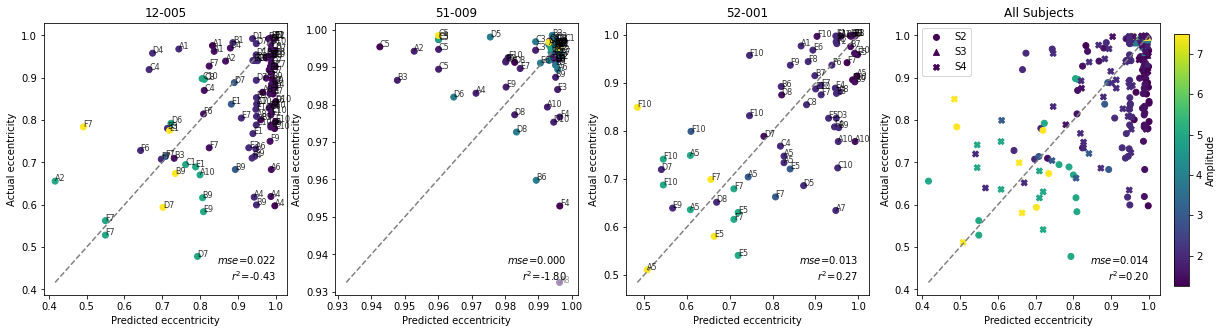

In [47]:
plot_averaged(data, eccentricity, modulate='Amp')
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

rholambdas = {  '12-005' : (410, 1190, 0.802, -0.031, 0.01386980325453202),
                '51-009' : (144, 1414, 0.152, 0.78, 0.006992905321139498),
                '52-001' : (437, 1420, 1.708, 0.648, 0.00992617959193387)}
bad_elecs = {'12-005' : [], '51-009' : ['B4', 'C6', 'B8', 'D7', "B10"], '52-001':[]}
subj_data = []
for i, subject in enumerate(data.subject.unique()):
    # get points
    df = data[data.subject == subject]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_ecc = get_averaged(df, eccentricity, modulate='Amp')
    avg_df = avg_df.dropna()
    avg_ecc = avg_ecc.dropna()
    avg_df['ecc'] = avg_ecc
    amps = avg_df.amp1
    
    
    # fit the model
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    model.a5 = rholambdas[subject][2]
    model.a6 = rholambdas[subject][3]
    model.a10=rholambdas[subject][4]
    # lr = LinearRegression()
    # lr.fit(np.array(freqs).reshape(-1, 1), np.array(avg_areas))
    # model.a10 = lr.coef_[0]
    # model.a6 = lr.intercept_
    
    # if subject == '12-005':
    #     model.a6, model.a10 = -0.2829508668414943, 0.01386980325453202
    # elif subject == '51-009':
    #     model.a6, model.a10 = 0.5385426635343504, 0.006992905321139498
    # elif subject == '52-001':
    #     model.a6, model.a10 = -1.6310288461517213, 0.00992617959193387
    #     #0.017678352500785532, 0#-0.04803093261331881
    # # print(model.a10)
    model.a5 = sols[subject].x[0]
    model.a6 = sols[subject].x[1]
    model.a10 = sols[subject].x[2]
    model.axlambda = sols[subject].x[3]
    model.rho = sols[subject].x[4]
    
    model.build()
    
    # simulate percepts
    avg_df['percept'] = avg_df.apply(get_percept, args=(model, implant), axis=1)
    
    avg_df['model_ecc'] = avg_df.percept.apply(phosphene_eccentricity)
    mse = np.mean((avg_df.model_ecc - avg_ecc)**2)
    
#     plt.sca(axes[0, i])
    
#     # scatterplot with areas, model line plot
#     plt.scatter(amps, avg_ecc, alpha=0.6)
    
# #     avg_drawing_sizes = avg_df.groupby(['freq'])['areas'].mean()
# #     std_drawing_sizes = avg_df.groupby(['freq'])['areas'].std()
# #     avg_drawing_amps = avg_df.groupby(['freq'])['areas'].mean().reset_index()['freq']
#     # plt.scatter(avg_drawing_amps, avg_drawing_sizes, alpha=0.8)
#     # plt.errorbar(avg_drawing_amps, avg_drawing_sizes, yerr=std_drawing_sizes, linestyle='', marker='o', capsize=5, capthick=2, label='Data')
    
#     means = avg_df.groupby(['amp1'])['model_ecc'].mean()
#     stds = avg_df.groupby(['amp1'])['model_ecc'].std()
#     amps1 = avg_df.groupby(['amp1'])['model_ecc'].mean().reset_index()['amp1'].unique()
#     plt.errorbar(amps1, means, yerr=stds, marker='+', color='black', ecolor='red', capsize=5, capthick=2, label=f"Model, mse: {mse : .2f}")
#     plt.plot(amps1, means, c='black', marker='+', label=f"Model, mse: {mse : .2f}")
    
#     plt.ylabel('Relative Size')
#     plt.xlabel('Freq (Hz)')
#     plt.legend()
    
    
    plt.sca(axes[i])
    plt.scatter(avg_df['model_ecc'], avg_ecc, c=avg_df['amp1'])
    
    
    for x, y, elec in zip(avg_df['model_ecc'], avg_ecc, avg_df.electrode1):
        plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
    maxval = max(avg_df['model_ecc'].max(), avg_ecc.max())
    minval = min(avg_df['model_ecc'].min(), avg_ecc.min())
    plt.plot( [minval,maxval],[minval,maxval] , linestyle='--', color='gray')
    
    # get r2 for model
    r = r2_score(avg_ecc, avg_df.model_ecc)
    a = plt.gca().axis()
    t = plt.text(maxval, minval, f"$mse$={mse:.3f}\n $r^2$={r:.2f}", va='bottom', ha='right')
    t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))
    
    plt.xlabel('Predicted eccentricity')
    plt.ylabel('Actual eccentricity')
    plt.title(subject)
    
    subj_data.append([avg_ecc, avg_df.model_ecc, avg_df.amp1])

plt.sca(axes[3])
maxval = max([max(np.max(row[0]), np.max(row[1])) for row in subj_data])
minval = min([min(np.min(row[0]), np.min(row[1])) for row in subj_data])
all_areas = []
all_model_areas = []
for (areas, model_areas, freqs), marker, subject in zip(subj_data, ['o', '^', 'X'], ['S2', 'S3', 'S4']):
    im = plt.scatter(model_areas, areas, c=freqs, marker=marker, label=subject)
    all_areas += list(areas)
    all_model_areas += list(model_areas)
plt.plot( [minval,maxval],[minval,maxval] , linestyle='--', color='gray')
plt.xlabel('Predicted eccentricity')
plt.ylabel('Actual eccentricity')
plt.title("All Subjects")
plt.legend()


all_areas = np.array(all_areas)
all_model_areas = np.array(all_model_areas)
mse = np.mean((all_areas - all_model_areas)**2)
r = r2_score(all_areas, all_model_areas)

a = plt.gca().axis()
t = plt.text(maxval, minval, f"$mse$={mse:.3f}\n$r^2$={r:.2f}", va='bottom', ha='right')
t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("Amplitude")#, rotation=0, y=-0.04, labelpad=-30)


In [42]:
def model_mse(a, model, implant, data):
    model.a5 = a[0]
    model.a6 = a[1]
    model.a10 = a[2]
    model.axlambda = a[3]
    model.rho = a[4]
    model.build()
    data['percepts'] = data.apply(get_percept, args=(model, implant), axis=1)
    data['model_ecc'] = data.percepts.apply(phosphene_eccentricity)
    return 1-r2_score(data.ecc, data.model_ecc)
    # return np.mean((data.model_ecc - data.ecc)**2)


In [43]:
from scipy.optimize import minimize, differential_evolution
sols = {}
for subject in data.subject.unique():
    print(subject)
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    model.a5 = rholambdas[subject][2]
    model.build()


    df = data[data.subject == subject]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_areas = get_averaged(df, eccentricity, modulate='Amp')
    avg_df = avg_df.dropna()
    avg_areas = avg_areas.dropna()
    avg_df['ecc'] = avg_areas
    
    sol = differential_evolution(model_mse, 
                                 ((0, 2), (-5, 5), (0, 1),(rholambdas[subject][1]/2, rholambdas[subject][1]*2), (rholambdas[subject][0]/2, rholambdas[subject][0]*2)), 
                                 args=(model, implant, avg_df), maxiter=100, popsize=5)
    print(sol)
    print()
    sols[subject] = sol 

    # print(model_mse([rholambdas[subject][2],rholambdas[subject][3], rholambdas[subject][4], rholambdas[subject][1], rholambdas[subject][0]], model, implant, avg_df))

12-005
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.16e+00 -4.18e+00  9.51e-02  1.22e+03  3.21e+02]
[ 1.48e+00 -3.40e+00  3.67e-02  7.79e+02  2.10e+02]
[ 1.48e+00 -3.40e+00  3.67e-02  7.79e+02  2.10e+02]
[ 1.48e+00 -3.40e+00  3.67e-02  7.79e+02  2.10e+02]
[ 1.48e+00 -3.40e+00  3.67e-02  7.79e+02  2.10e+02]
[ 1.48e+00 -3.40e+00  3.67e-02  7.79e+02  2.10e+02]
[ 1.48e+00 -3.40e+00  3.67e-02  7.79e+02  2.10e+02]
[ 1.53e+00 -3.21e+00  5.14e-02  1.02e+03  2.07e+02]
[ 1.53e+00 -3.21e+00  5.14e-02  1.02e+03  2.07e+02]
[ 1.53e+00 -3.21e+00  5.14e-02  1.02e+03  2.07e+02]
[ 1.5

In [222]:
print(model_mse([0.36712, -2.022, 0.0739, 1346, rholambdas[subject][0]], model, implant, avg_df))

0.7723432665126676


In [49]:
print(sols)

{'12-005':      fun: 1.425532141954769
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 2531
     nit: 100
 success: False
       x: array([ 4.39e-01, -3.73e+00,  1.56e-01,  6.22e+02,  2.34e+02]), '51-009':      fun: 1.3732779681469074
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 2531
     nit: 100
 success: False
       x: array([ 5.64e-03, -1.99e+00,  1.02e-01,  2.16e+03,  1.18e+02]), '52-001':      fun: 0.7349495820085716
 message: 'Optimization terminated successfully.'
    nfev: 1481
     nit: 58
 success: True
       x: array([ 4.39e-01, -3.28e+00,  1.33e-01,  8.83e+02,  3.21e+02])}


In [48]:
[list(s.x) for s in sols.values()]

[[0.43872050801986984,
  -3.7321742476913258,
  0.15642703888564258,
  621.7104851907188,
  234.20288368721737],
 [0.005639073836291586,
  -1.9873885889930691,
  0.10211354127825722,
  2163.192442354507,
  117.75860697058268],
 [0.4390271168180835,
  -3.282144424746105,
  0.13272681580962126,
  883.2189804960044,
  321.47607792628787]]